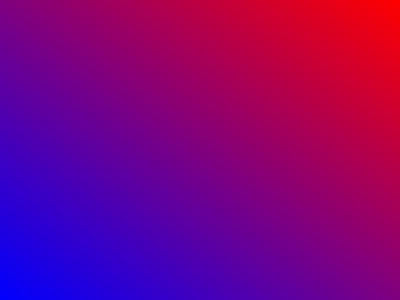

In [47]:
import numpy as np
from PIL import Image
from IPython.display import display
from PIL.Image import new as createImage


def create_linear_gradient(width, height, start_color, end_color, angle):
    """
    创建具有任意角度的线性渐变背景

    :param width: 图像宽度
    :param height: 图像高度
    :param start_color: 起始颜色，(R, G, B) 元组，值范围 0-255
    :param end_color: 结束颜色，(R, G, B) 元组，值范围 0-255
    :param angle: 渐变角度，以度为单位，0 度表示从左到右，顺时针方向
    :return: Pillow 图像对象
    """
    # 将角度转换为弧度
    angle_rad = np.deg2rad(angle % 360)

    # 创建坐标网格
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    x_grid, y_grid = np.meshgrid(x, y)

    # 计算投影
    # 调整坐标系，使原点在图像中心
    x_grid -= 0.5
    y_grid -= 0.5

    # 计算在渐变方向上的投影
    # 渐变方向的单位向量
    gradient_vector = np.array([np.cos(angle_rad), np.sin(angle_rad)])
    # 将坐标点展平成二维数组
    coords = np.stack((x_grid.ravel(), y_grid.ravel()), axis=1)
    # 计算每个点在渐变方向上的投影
    projections = np.dot(coords, gradient_vector)
    # 将投影值归一化到 [0, 1]
    projections = (projections - projections.min()) / \
        (projections.max() - projections.min())
    projections = projections.reshape((height, width))

    # 计算渐变颜色
    start_color = np.array(start_color).reshape(1, 1, 3)
    end_color = np.array(end_color).reshape(1, 1, 3)
    gradient = start_color + (end_color - start_color) * \
        projections[:, :, np.newaxis]

    # 确保颜色值在正确范围内
    gradient = np.clip(gradient, 0, 255).astype(np.uint8)

    # 将 NumPy 数组转换为 Pillow 图像
    image = Image.fromarray(gradient)

    return image


# 使用示例
if __name__ == "__main__":
    width, height = 400, 300
    start_color = (255, 0, 0)  # 红色
    end_color = (0, 0, 255)    # 蓝色
    angle = 135  # 渐变角度

    gradient_image = create_linear_gradient(
        width, height, start_color, end_color, angle)
    display(gradient_image)  # 显示图像
    # gradient_image.save("gradient.png")  # 保存图像

In [46]:
import numpy as np
from PIL import Image
from PIL.Image import new as createImage
from IPython.display import display


def add_black_white_noise_to_image(image: Image.Image, density=0.05) -> Image.Image:
    """
    在现有图像上添加黑白噪点。

    :param image: 输入的 Pillow 图像对象
    :param density: 噪点密度（0到1之间的浮点数）
    :return: 添加噪点后的 Pillow 图像对象
    """
    # 转换图像为 NumPy 数组
    image_array = np.array(image)

    # 如果图像是灰度模式，扩展维度
    if image_array.ndim == 2:
        image_array = np.stack([image_array]*3, axis=-1)

    height, width, channels = image_array.shape

    # 生成随机数矩阵
    random_matrix = np.random.rand(height, width)

    # 确定噪点位置
    noise_positions = random_matrix < density

    # 生成噪点颜色（黑色或白色）
    noise_colors = np.where(np.random.rand(
        height, width, 1) <= 0.05, 0, 255).astype(np.uint8)

    zeors = np.zeros((height, width), dtype=np.uint8)
    zeors[0:20][:] = 1

    # 将噪点应用到图像
    image_array[noise_positions & (zeors == 1)] = noise_colors[noise_positions]

    # 转换回 Pillow 图像
    noisy_image = Image.fromarray(image_array)

    return noisy_image


# 使用示例
if __name__ == "__main__":
    # 创建一个浅红色背景
    width, height = 400, 300
    original_image = createImage(mode='RGB', size=(
        width, height), color=(255, 192, 192))

    # 添加噪点
    density = 0.5  # 5%的像素为噪点
    noisy_image = add_black_white_noise_to_image(original_image, density)

    # 显示结果
    # noisy_image.show()

    display(noisy_image)  # 显示图像

    # 保存结果
    # noisy_image.save("noisy_image.png")

ValueError: shape mismatch: value array of shape (59962,1) could not be broadcast to indexing result of shape (3957,3)

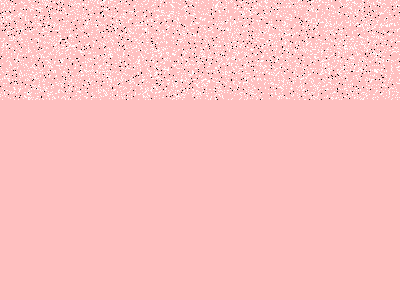

In [87]:
from PIL import Image
import numpy as np
import random
from PIL.Image import new as createImage
from IPython.display import display


def generate_black_white_noise(width, height, density=0.05):
    """
    生成黑白随机噪点数组。

    :param width: 噪点区域的宽度
    :param height: 噪点区域的高度
    :param density: 噪点密度（0到1之间的浮点数）
    :return: 一个 (height, width, 3) 的 NumPy 数组，包含黑白噪点
    """
    # 生成随机数矩阵
    random_matrix = np.random.rand(height, width)

    # 确定噪点位置
    noise_mask = random_matrix < density

    # 随机选择黑色或白色
    # 50% 选择黑色，50% 选择白色
    noise_colors = np.where(np.random.rand(
        height, width, 1) < 0.1, 0, 255).astype(np.uint8)

    return noise_mask, noise_colors


def add_black_white_noise_to_region(image, region, density=0.05):
    """
    在给定图像的指定区域内添加黑白噪点，而不改变其他区域。

    :param image: Pillow Image 对象
    :param region: 噪点区域的边界框 (left, upper, right, lower)
    :param density: 噪点密度（0到1之间的浮点数）
    :return: 添加噪点后的 Pillow Image 对象
    """
    left, upper, right, lower = region
    width = right - left
    height = lower - upper

    # 转换图像为 NumPy 数组
    image_array = np.array(image)

    # 提取指定区域的像素
    region_array = image_array[upper:lower, left:right].copy()

    # 生成噪点掩码和噪点颜色
    noise_mask, noise_colors = generate_black_white_noise(
        width, height, density)

    # 应用噪点：将噪点颜色覆盖到噪点掩码为 True 的位置
    region_array[noise_mask] = noise_colors[noise_mask]

    # 更新原图像的指定区域
    image_array[upper:lower, left:right] = region_array

    # 转换回 Pillow 图像
    noisy_image = Image.fromarray(image_array)

    return noisy_image


if __name__ == "__main__":
    # 加载图像并确保其为 RGB 模式
    # 创建一个浅红色背景
    width, height = 400, 300
    image = createImage(mode='RGB', size=(
        width, height), color=(255, 192, 192))

    # 定义噪点区域和密度
    noise_region = (0, 0, width, 100)  # (left, upper, right, lower)
    density = 0.2  # 10%的像素为噪点

    # 添加噪点
    noisy_image = add_black_white_noise_to_region(image, noise_region, density)

    display(noisy_image)  # 显示图像

    # 保存结果
    # noisy_image.save('image_with_noise.jpg')  # 替换为所需保存路径

In [ ]:
import math

min(2, 3)

AttributeError: module 'math' has no attribute 'min'